## **¿Qué es y Para Qué Sirve un Bloque Squeeze-and-Excitation? 🤔**

Imagina una capa convolucional que extrae 64 características (canales) diferentes de una imagen. Algunas de esas características son muy importantes para la tarea (ej. la textura del pelo de un gato), mientras que otras son menos relevantes (ej. el color de fondo).

Un bloque Squeeze-and-Excitation actúa como un "controlador de atención" inteligente. Su trabajo es:

- Analizar la información de todos los canales.

- Aprender qué canales son más importantes en ese momento.

- "Subir el volumen" (amplificar) a los canales importantes y "bajar el volumen" (suprimir) a los menos importantes.

En resumen, le permite a la red recalibrar dinámicamente sus características para enfocarse en lo que realmente importa.

## **SE-ResNet-50**

¿Dónde y Por Qué se Añade el Bloque SE?

El lugar estratégico para colocar el bloque SE es después de que el "camino principal" del bloque residual haya hecho su trabajo, pero justo antes de que se sume con la información del atajo.

El flujo dentro del bloque cuello de botella modificado sería así:

- Camino Principal: La entrada pasa por las tres capas convolucionales (1x1 -> 3x3 -> 1x1).

- Aplicar SE: La salida de este camino principal se pasa a nuestro bloque se_block. El bloque SE aprende a recalibrar los canales, potenciando los más útiles.

- Suma Final: La salida ya recalibrada por el SE se suma con la entrada del atajo (x_atajo).

Al hacerlo de esta forma, el bloque SE ayuda a que el bloque residual se enfoque en las características más informativas antes de pasar la información a la siguiente capa.


## **La Arquitectura de ResNet-50**

La estructura general es similar a ResNet-34, pero con los bloques de cuello de botella:

- Capa inicial: Conv2D de 7x7 con MaxPooling.

Cuatro Etapas:

- Etapa 2 (conv2_x): 3 bloques de cuello de botella con 64 filtros internos, output 256.

- Etapa 3 (conv3_x): 4 bloques de cuello de botella con 128 filtros internos, output 512.

- Etapa 4 (conv4_x): 6 bloques de cuello de botella con 256 filtros internos, output 1024.

- Etapa 5 (conv5_x): 3 bloques de cuello de botella con 512 filtros internos, output 2048.

- Capa final: AveragePooling y Dense para clasificación.

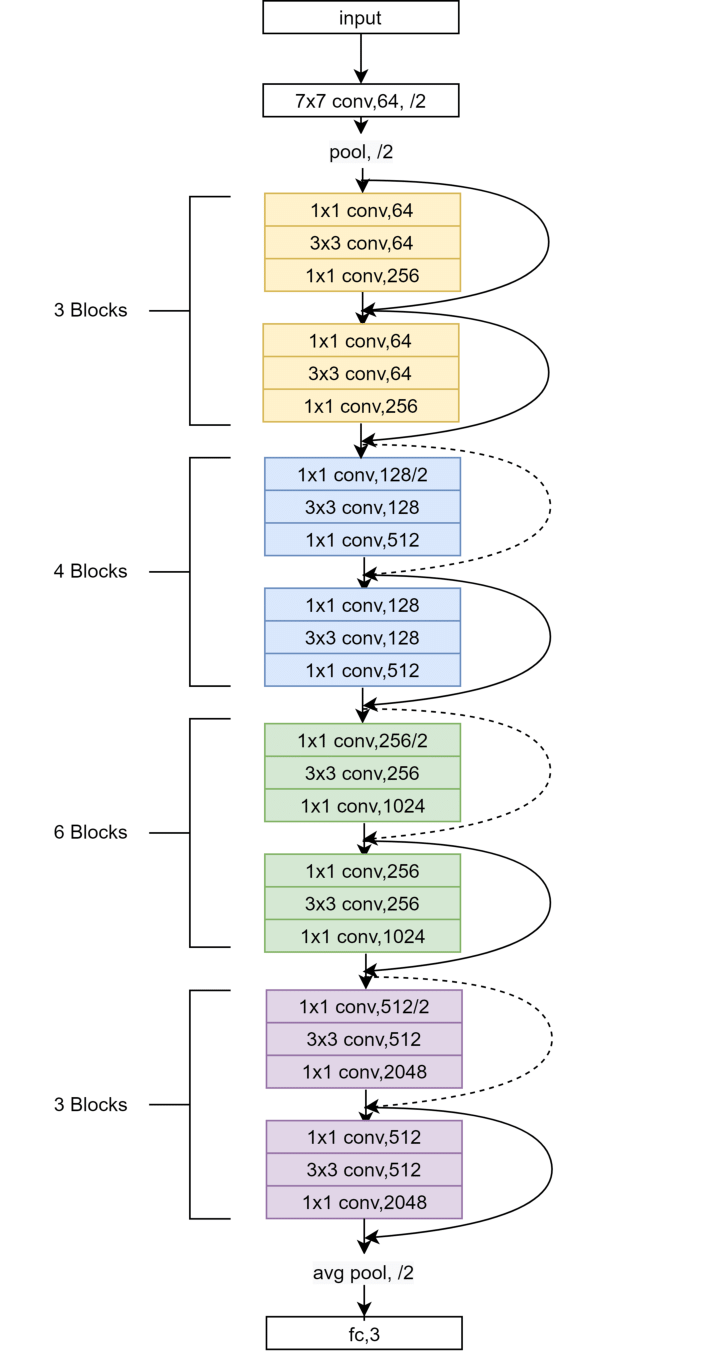

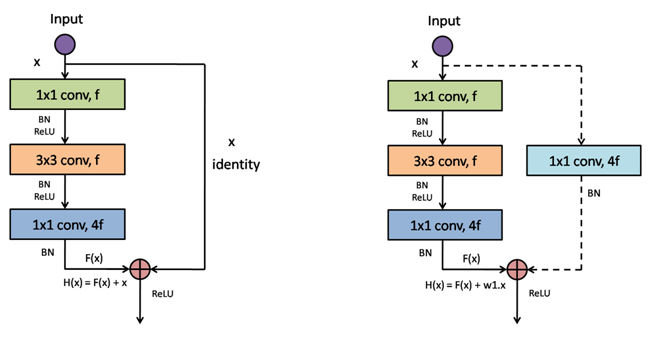

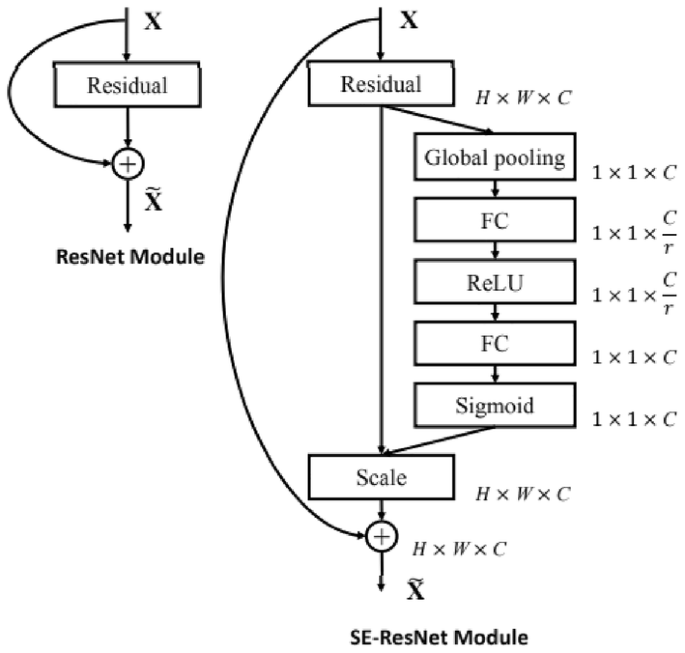

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Multiply
from tensorflow.keras.models import Model

In [ ]:
# --- 1. El Bloque Squeeze-and-Excitation (sin cambios) ---
def se_block(input_tensor, ratio=16):
    """
    Crea un bloque Squeeze-and-Excitation.
    """
    init_filters = input_tensor.shape[-1]
    se_shape = (1, 1, init_filters)

    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    se = Dense(init_filters // ratio, activation='relu', use_bias=False)(se)
    se = Dense(init_filters, activation='sigmoid', use_bias=False)(se)

    output_tensor = Multiply()([input_tensor, se])
    return output_tensor

In [ ]:
# --- 2. El Bloque Cuello de Botella MODIFICADO con SE ---
def bloque_residual_bottleneck(x, filtros_internos, stage_filters, stride=1, es_atajo_convolucional=False):
    """
    Un bloque residual con arquitectura de cuello de botella Y un bloque SE integrado.
    """
    F1, F2, F3 = filtros_internos
    x_atajo = x

    # Primera 1x1 CONV
    x = Conv2D(F1, kernel_size=1, strides=stride, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Segunda 3x3 CONV
    x = Conv2D(F2, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Tercera 1x1 CONV
    x = Conv2D(F3, kernel_size=1, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    # ++++++++ AQUÍ INTEGRAMOS EL BLOQUE SE ++++++++
    x = se_block(x)
    # ++++++++++++++++++++++++++++++++++++++++++++++

    ##### ATADO (SKIP CONNECTION) #####
    if es_atajo_convolucional:
        x_atajo = Conv2D(stage_filters, kernel_size=1, strides=stride, padding='valid')(x_atajo)
        x_atajo = BatchNormalization()(x_atajo)

    # Sumamos la salida del camino principal (ya recalibrada por SE) con la del atajo
    x = Add()([x, x_atajo])
    x = Activation('relu')(x)

    return x

### **Porque el primer bloque se aplica atajo convolucional**


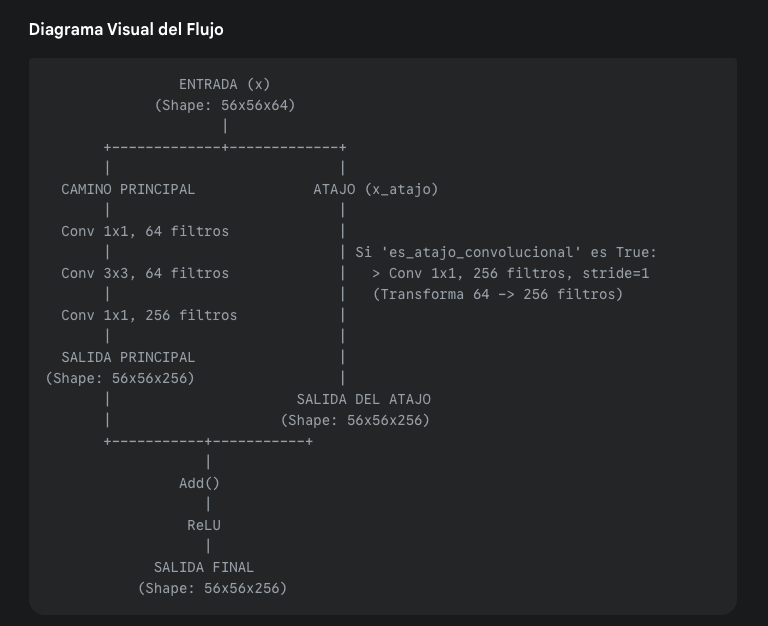

In [ ]:
def crear_resnet50(input_shape=(224, 224, 3), num_clases=1000):
    """
    Construye el modelo ResNet-50 completo.
    """
    inputs = Input(shape=input_shape)

    # Etapa 1 (conv1)
    x = Conv2D(64, kernel_size=7, strides=2, padding='same', name='conv1_pad')(inputs)
    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='pool1')(x)

    # Etapa 2 (conv2_x) - 3 bloques de cuello de botella
    # Primer bloque: stride=1, el atajo es convolucional para cambiar de 64 a 256 filtros
    x = bloque_residual_bottleneck(x, [64, 64, 256], 256, stride=1, es_atajo_convolucional=True)
    x = bloque_residual_bottleneck(x, [64, 64, 256], 256, stride=1, es_atajo_convolucional=False) # Los siguientes son bloques identidad
    x = bloque_residual_bottleneck(x, [64, 64, 256], 256, stride=1, es_atajo_convolucional=False)

    # Etapa 3 (conv3_x) - 4 bloques de cuello de botella
    # Primer bloque: stride=2, el atajo es convolucional para cambiar de 256 a 512 filtros y reducir dimensiones
    x = bloque_residual_bottleneck(x, [128, 128, 512], 512, stride=2, es_atajo_convolucional=True)
    x = bloque_residual_bottleneck(x, [128, 128, 512], 512, stride=1, es_atajo_convolucional=False)
    x = bloque_residual_bottleneck(x, [128, 128, 512], 512, stride=1, es_atajo_convolucional=False)
    x = bloque_residual_bottleneck(x, [128, 128, 512], 512, stride=1, es_atajo_convolucional=False)

    # Etapa 4 (conv4_x) - 6 bloques de cuello de botella
    # Primer bloque: stride=2, el atajo es convolucional para cambiar de 512 a 1024 filtros y reducir dimensiones
    x = bloque_residual_bottleneck(x, [256, 256, 1024], 1024, stride=2, es_atajo_convolucional=True)
    x = bloque_residual_bottleneck(x, [256, 256, 1024], 1024, stride=1, es_atajo_convolucional=False)
    x = bloque_residual_bottleneck(x, [256, 256, 1024], 1024, stride=1, es_atajo_convolucional=False)
    x = bloque_residual_bottleneck(x, [256, 256, 1024], 1024, stride=1, es_atajo_convolucional=False)
    x = bloque_residual_bottleneck(x, [256, 256, 1024], 1024, stride=1, es_atajo_convolucional=False)
    x = bloque_residual_bottleneck(x, [256, 256, 1024], 1024, stride=1, es_atajo_convolucional=False)

    # Etapa 5 (conv5_x) - 3 bloques de cuello de botella
    # Primer bloque: stride=2, el atajo es convolucional para cambiar de 1024 a 2048 filtros y reducir dimensiones
    x = bloque_residual_bottleneck(x, [512, 512, 2048], 2048, stride=2, es_atajo_convolucional=True)
    x = bloque_residual_bottleneck(x, [512, 512, 2048], 2048, stride=1, es_atajo_convolucional=False)
    x = bloque_residual_bottleneck(x, [512, 512, 2048], 2048, stride=1, es_atajo_convolucional=False)

    # Capas finales
    x = AveragePooling2D(pool_size=(7, 7), name='avg_pool')(x) # el tamaño del pool_size debe ser el de la característica actual (7x7 por 224x224 entrada)
    x = Flatten(name='flatten')(x)
    outputs = Dense(num_clases, activation='softmax', name='fc' + str(num_clases))(x)

    # Creamos el modelo final
    model = Model(inputs=inputs, outputs=outputs, name='ResNet50')
    return model

In [ ]:
INPUT_SHAPE = (224, 224, 3)
NUM_CLASES = 1000

modelo_resnet50 = crear_resnet50(input_shape=INPUT_SHAPE, num_clases=NUM_CLASES)

modelo_resnet50.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

modelo_resnet50.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 112, 112,  │        256 │ conv1_pad[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ conv1_relu[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 56, 56,    │      4,160 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 56, 56,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     16,640 │ activation_1[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 256) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 16)  │      4,096 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 256) │      4,096 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     16,640 │ pool1[0][0]     

 Total params: 28,151,656 (107.39 MB)

 Trainable params: 28,098,536 (107.19 MB)

 Non-trainable params: 53,120 (207.50 KB)